In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms
from avgn.visualization.spectrogram import draw_spec_set
from avgn.visualization.quickplots import draw_projection_plots

In [5]:
from soundsig.sound import BioSound 

In [6]:
from avgn.visualization.projections import scatter_spec
from avgn.utils.general import save_fig
from avgn.utils.paths import FIGURE_DIR, ensure_dir

### Collect data

In [7]:
DATASET_ID = 'BIRD_DB_Vireo_cassinii'

In [8]:
df_loc =  DATA_DIR / "projections_comparison" / "cassins_comparison.pickle"
df_loc

PosixPath('/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/projections_comparison/cassins_comparison.pickle')

In [9]:
syllable_df = pd.read_pickle(df_loc)

In [10]:
syllable_df[:3]

,specs,PAF,UMAP_PAF,UMAP_spec,LDA_PAF,LDA_spec,train_mask,labels,index,fund,...,kurtS,entS,q1,q2,q3,meanT,stdT,skewT,kurtT,entT
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3237649, 0.4...","[-0.9803453, 0.7167356, -0.98172635, -0.682574...","[-0.9264683723449707, -1.523571491241455]","[1.2414824962615967, 2.306623935699463]","[3.734930140295408, 0.9901506956945839]","[1.3243382066036455, -0.40738563161856656]",True,1,0,2723.052406,...,16.696955,0.617858,2928.515625,3359.179688,3660.644531,0.144487,0.062899,-0.093658,2.219679,0.980332
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.1318547, 0.128302...","[0.06215179, -0.78374857, -1.4247988, -0.69023...","[-0.43083474040031433, -1.8440558910369873]","[2.0969467163085938, 2.211822748184204]","[2.38671754793209, -1.0968161770154037]","[2.229822900409332, 1.0468786796007112]",False,1,1,3021.447540,...,27.281679,0.555706,2928.515625,3316.113281,3445.312500,0.168187,0.073403,-0.040624,2.230751,0.979186
2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1.5548859, -1.4059776, -0.7953217, 1.190703, ...","[6.1309494972229, -0.6232298612594604]","[4.290624618530273, 11.895524978637695]","[4.661104017142606, 1.3625538898570537]","[-0.6556465431533327, 5.957525778298246]",False,5,12,3448.714523,...,6.794279,0.566811,3359.179688,3531.445312,3746.777344,0.113123,0.057371,0.229053,1.837216,0.966494


In [11]:
syllable_df.columns

Index(['specs', 'PAF', 'UMAP_PAF', 'UMAP_spec', 'LDA_PAF', 'LDA_spec',
       'train_mask', 'labels', 'index', 'fund', 'cvfund', 'maxfund', 'minfund',
       'sal', 'meanS', 'stdS', 'skewS', 'kurtS', 'entS', 'q1', 'q2', 'q3',
       'meanT', 'stdT', 'skewT', 'kurtT', 'entT'],
      dtype='object')

### Make projections

In [12]:
from cuml.manifold.umap import UMAP as cumlUMAP

In [13]:
def add_noise(signal, snr, db = False):
    ''' 
    signal: np.ndarray
    snr: float

    returns -> np.ndarray
    https://stackoverflow.com/questions/54323143/add-white-noise-on-image-based-on-snr
    '''

    # Generate the noise as you did
    noise = np.random.random(size=signal.shape)
    # For the record I think np.random.random does exactly the same thing

    # work out the current SNR
    if db:
        current_snr = 10 * np.log10(np.mean(signal) / np.std(noise))
    else:
        current_snr = np.mean(signal) / np.std(noise)

    # scale the noise by the snr ratios (smaller noise <=> larger snr)
    noise *= (current_snr / snr)

    # return the new signal with noise
    return signal + noise

In [14]:
specs = syllable_df.specs.values

In [15]:
labs = syllable_df.labels.values

In [16]:
print(np.shape(specs), np.shape(labs))

(26982,) (26982,)


In [17]:
noise_levels = np.logspace(-5, 3, num=10, base=2)
print(noise_levels)

[0.03125    0.05786717 0.1071555  0.19842513 0.36743362 0.680395
 1.25992105 2.33305808 4.32023896 8.        ]


[0.03125    0.03783492 0.04580739 0.0554598  0.06714614 0.081295
 0.09842526 0.11916517 0.14427533 0.17467664 0.21148404 0.25604739
 0.31000101 0.3753236  0.45441078 0.550163   0.66609188 0.80644898
 0.97638175 1.18212231 1.43121596 1.73279796 2.09792851 2.5399984
 3.07522007 3.72322222 4.50776964 5.45763481 6.60765302 8.        ]


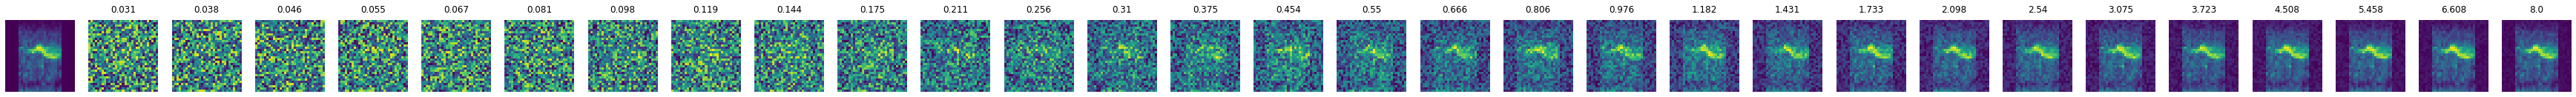

In [18]:
spec = specs[0]
noise_levels = np.logspace(-5, 3, num=30, base=2)
print(noise_levels)
fig, axs = plt.subplots(ncols = len(noise_levels)+1, figsize=((len(noise_levels)+1)*2, 2))
axs[0].matshow(spec, origin='lower')
axs[0].axis('off')
for nli, noise_level in enumerate(noise_levels):
    nli +=1
    ax = axs[nli]
    ax.matshow(add_noise(spec, noise_level), origin="lower")
    ax.axis('off')
    ax.set_title(np.round(noise_level,3))

In [19]:
from sklearn.metrics import silhouette_score

In [20]:
np.shape(np.array(specs))

(26982,)

In [21]:
(len(specs), np.product(np.shape(specs[0])))

(26982, 992)

In [22]:
flat_specs = np.vstack(specs).reshape((len(specs), np.product(np.shape(specs[0]))))

In [23]:
from sklearn.manifold import MDS
from sklearn.decomposition import PCA

In [68]:
results_df = pd.DataFrame(columns = ['embedding', 'snr', 'silhouette'])
for nli, snr in enumerate(tqdm(noise_levels)):
    
    print('specs')
    # specs
    noised_specs = np.array(add_noise(flat_specs, snr))
    score = silhouette_score(list(noised_specs), labels = labs)
    results_df.loc[len(results_df)] = ["spec", snr, score]
    
    print('umap')
    # UMAP
    cuml_umap = cumlUMAP(n_components = 2)
    z_features = cuml_umap.fit_transform(noised_specs)
    score = silhouette_score(list(z_features), labels = labs)
    results_df.loc[len(results_df)] = ["UMAP", snr, score]
    
    # PCA
    print('pca')
    pca = PCA(n_components=2)
    z_features = pca.fit_transform(noised_specs)
    score = silhouette_score(list(z_features), labels = labs)
    results_df.loc[len(results_df)] = ["PCA-2", snr, score]
    
    # PCA
    print('pca')
    pca = PCA(n_components=50)
    z_features = pca.fit_transform(noised_specs)
    score = silhouette_score(list(z_features), labels = labs)
    results_df.loc[len(results_df)] = ["PCA-50", snr, score]
    
    # mds is very slow
    if False:
        print('mds')
        mds = MDS(n_components=2, n_jobs=-1, metric=False)
        z_features = mds.fit_transform(noised_specs)
        score = silhouette_score(list(z_features), labels = labs)
        results_df.loc[len(results_df)] = ["MDS", snr, score]

specs
umap
pca
pca
mds
specs
umap
pca
pca
mds
specs
umap
pca
pca
mds
specs
umap
pca
pca
mds
specs
umap
pca
pca
mds
specs
umap
pca
pca
mds
specs
umap
pca
pca
mds
specs
umap
pca
pca
mds
specs
umap
pca
pca
mds
specs
umap
pca
pca
mds
specs
umap
pca
pca
mds
specs
umap
pca
pca
mds
specs
umap
pca
pca
mds
specs
umap
pca
pca
mds
specs
umap
pca
pca
mds
specs
umap
pca
pca
mds
specs
umap
pca
pca
mds
specs
umap
pca
pca
mds
specs
umap
pca
pca
mds
specs
umap
pca
pca
mds
specs
umap
pca
pca
mds
specs
umap
pca
pca
mds
specs
umap
pca
pca
mds
specs
umap
pca
pca
mds
specs
umap
pca
pca
mds
specs
umap
pca
pca
mds
specs
umap
pca
pca
mds
specs
umap
pca
pca
mds
specs
umap
pca
pca
mds
specs
umap
pca
pca
mds



In [25]:
results_df[:3]

,embedding,snr,silhouette
0,spec,0.03125,-0.000627
1,UMAP,0.03125,-0.023627
2,PCA-2,0.03125,-0.075436


In [26]:
import seaborn as sns

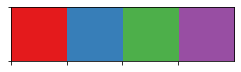

In [27]:
embedding_types = np.unique(results_df.embedding.values)
pal = sns.color_palette('Set1', len(embedding_types))
sns.palplot(pal)

In [29]:
def norm(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

In [60]:
import matplotlib

In [63]:
labdict = {'spec': 'Spec.', 'UMAP':'UMAP', 'PCA-2': 'PCA (2)', 'PCA-50': 'PCA (50)'}

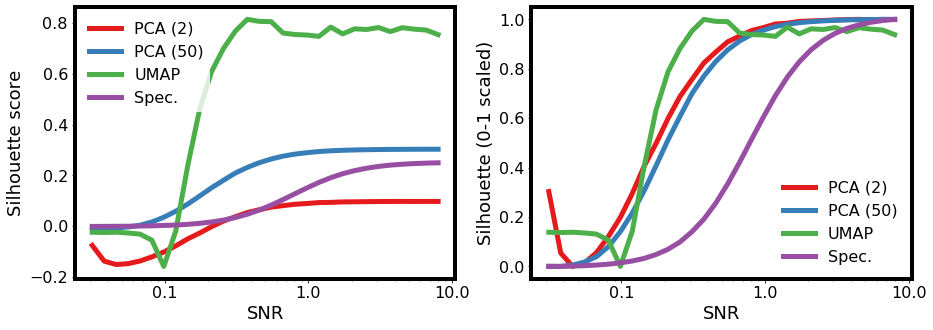

In [67]:
fig, axs = plt.subplots(ncols = 2, figsize=(15,5))

ax = axs[0]
for eti, embedding_type in enumerate(embedding_types):
    snr = results_df[results_df.embedding==embedding_type].snr
    silhouette = results_df[results_df.embedding==embedding_type].silhouette
    ax.plot(snr, silhouette, color = pal[eti], label=labdict[embedding_type], lw=5)
ax.set_ylabel('Silhouette score', fontsize=label_fs)


ax = axs[1]
for eti, embedding_type in enumerate(embedding_types):
    snr = results_df[results_df.embedding==embedding_type].snr
    silhouette = results_df[results_df.embedding==embedding_type].silhouette
    silhouette = norm(silhouette)  
    ax.plot(snr, silhouette, color = pal[eti], label=labdict[embedding_type], lw=5)
ax.set_ylabel('Silhouette (0-1 scaled)', fontsize=label_fs)

label_fs = 18
for ax in axs.flatten():
    ax.set_xlabel('SNR', fontsize=label_fs)
    ax.set_xscale('log')
    [i.set_linewidth(4) for i in ax.spines.values()]
    ax.xaxis.set_tick_params(labelsize=16)
    ax.yaxis.set_tick_params(labelsize=16)
    leg = ax.legend(fontsize=16)
    leg.get_frame().set_linewidth(0.0)
    ax.set_xticks([.1, 1, 10])
    ax.set_xticklabels(['0.1', '1', '10'])
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ensure_dir(FIGURE_DIR/'SNR')
save_fig(FIGURE_DIR / 'SNR' / 'SNR_cassins', save_pdf=True)